<a href="https://colab.research.google.com/github/aureavaleria/DataBalancing-Research/blob/main/papers/Artigo%201/V5/Vers%C3%A3o_5_(Desenvolvimento_de_uma_nova_t%C3%A9cnica_AHC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Machine learning for predicting liver and/or lung metastasis in colorectal cancer: A retrospective study based on the SEER database***

Este estudo propõe um modelo de aprendizado de máquina para prever o risco de metástase hepática e/ou pulmonar em pacientes com câncer colorretal (CRC). A partir da base de dados SEER, foram extraídos dados aproximadamente 53 mil pacientes com diagnóstico patológico de CRC entre 2010 e 2015, desenvolvendo sete modelos de algoritmos(Decision tree, Randon Forest, Naive Bayes,  KNN,XGBoost, Gradient Boosting.

### Parte 1:  Importação das Bibliotecas e Carregamento do Dataset

Nesta etapa, importamos as bibliotecas necessárias para análise e carregamos o dataset. Realizamos uma verificação inicial para identificar e remover valores faltantes e definimos as variáveis preditoras (X) e as variáveis alvo (y), preparando os dados para o pré-processamento e a modelagem.

In [ ]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd


# Carregar o dataset
df = pd.read_csv('https://raw.githubusercontent.com/aureavaleria/dataset/refs/heads/main/export.csv')
df.dropna(inplace=True)

# Definir as variáveis preditoras e a variável alvo
X = df[['Age recode with <1 year olds', 'Sex', 'Race recode (White, Black, Other)',
        'Histologic Type ICD-O-3', 'Grade Recode (thru 2017)', 'Primary Site',
        'Derived AJCC T, 7th ed (2010-2015)', 'Derived AJCC N, 7th ed (2010-2015)',
        'CS tumor size (2004-2015)', 'CEA Pretreatment Interpretation Recode (2010+)',
        'Tumor Deposits Recode (2010+)', 'Marital status at diagnosis']]

y_liver = df['SEER Combined Mets at DX-liver (2010+)']
y_lung = df['SEER Combined Mets at DX-lung (2010+)']

y = pd.concat([y_liver, y_lung], axis=1)

###Parte 2:  Preparação das Variáveis Alvo e Codificação de Variáveis Categóricas

Nesta etapa, preparamos as variáveis alvo (y), combinando as informações de metástase hepática e pulmonar em uma coluna binária para indicar a presença de metástase. Também aplicamos LabelEncoder para transformar variáveis categóricas de X em valores numéricos, facilitando o uso dos dados em modelos de aprendizado de máquina.

In [ ]:
y = pd.concat([y_liver, y_lung], axis=1)

# Aplicar codificação a variáveis categóricas em 'X' usando LabelEncoder, para prepará-las para o modelo
for col in X.columns:
    if X[col].dtype == 'object':  # Verifica se a coluna é categórica (strings)
        X[col] = LabelEncoder().fit_transform(X[col])

# Função para combinar as informações de metástase hepática e pulmonar em uma coluna binária 'Binary Mets'
def combine_mets_binary(row):
    if row['SEER Combined Mets at DX-liver (2010+)'] == 'Yes' or row['SEER Combined Mets at DX-lung (2010+)'] == 'Yes':
        return 1  # Com metástase
    else:
        return 0  # Sem metástase

# Aplicar a função para criar a nova coluna binária 'Binary Mets' em 'y'
y['Binary Mets'] = y.apply(combine_mets_binary, axis=1)

# Verificar se 'X' e 'y' têm o mesmo número de amostras
print(f"Tamanho de X: {len(X)}")
print(f"Tamanho de y: {len(y)}")

# Salvar o DataFrame 'y' em um arquivo CSV para referência futura ou análise adicional
y.to_csv('/content/Y.csv')

<ipython-input-2-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-2-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-2-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Tamanho de X: 53448
Tamanho de y: 53448


###Parte 3: Definição e Configuração dos Modelos de Aprendizado de Máquina e Validação Cruzada

Aqui, configuramos os principais algoritmos de aprendizado de máquina, incluindo Decision Tree, Random Forest, SVM, Naive Bayes, KNN, XGBoost e Gradient Boosting. Cada modelo é definido com parâmetros específicos para otimizar o desempenho. Em seguida, aplicamos uma validação cruzada estratificada com 5 divisões para avaliar e comparar a performance dos modelos de maneira consistente e robusta.

In [ ]:
# Definição dos modelos de aprendizado de máquina com hiperparâmetros ajustados
models = {
    "Decision Tree": DecisionTreeClassifier(
        criterion='gini',
        max_depth=5,
        min_samples_leaf=10,
        min_samples_split=2,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        bootstrap=True,
        criterion='entropy',
        max_depth=15,
        min_samples_leaf=5,
        min_samples_split=2,
        n_estimators=300,
        random_state=42
    ),
    "SVM": SVC(
        kernel='poly',
        gamma='scale',
        degree=3,
        C=10,
        probability=True,
        random_state=42
    ),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(
        leaf_size=20,
        metric='manhattan',
        n_neighbors=11,
        weights='uniform'
    ),
    "XGBoost": XGBClassifier(
        colsample_bytree=0.6,
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        reg_alpha=0.1,
        reg_lambda=10.0,
        subsample=1.0,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        max_depth=3,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        min_samples_leaf=5,
        min_samples_split=2,
        random_state=42
    )
}

# Configuração da validação cruzada estratificada com 5 divisões (folds)
# Isso garante que a proporção de classes seja mantida em cada divisão, e o shuffle embaralha os dados antes de dividir
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

MST SMOTE


### Parte 4: Avaliação e Comparação dos Modelos de Aprendizado de Máquina em Conjuntos de Treino, Validação e Teste


Este bloco de código implementa a validação cruzada para treinar e avaliar os modelos de aprendizado de máquina definidos no pipeline. Ele utiliza a técnica de K-Fold Cross-Validation para dividir os dados em múltiplos folds, garantindo uma avaliação robusta do desempenho dos modelos. Durante cada fold, os dados de treinamento são balanceados utilizando o SMOTE e escalados com o StandardScaler. Métricas de desempenho, como precisão, recall, F1-Score, especificidade, AUC-ROC e AUPR, são calculadas tanto para o conjunto de treinamento quanto para o conjunto de teste. Além disso, visualizações como matrizes de confusão e curvas ROC e Precisão-Recall são geradas. Ao final, as métricas médias de todos os folds são compiladas para comparação.

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# ---------------------------------------------------
# Classe MST_SMOTE_Clustering (modificada)
# ---------------------------------------------------
class MST_SMOTE_Clustering:
    def __init__(self, clustering_method='kmeans', n_clusters=5, eps=0.5, min_samples=5):
        self.clustering_method = clustering_method
        self.n_clusters = n_clusters
        self.eps = eps
        self.min_samples = min_samples

    def fit_resample(self, X, y):
        if isinstance(y, pd.DataFrame):
            y = y.iloc[:, 0]

        classes, counts = np.unique(y, return_counts=True)
        minority_class = classes[np.argmin(counts)]

        mask = (y == minority_class).values
        X_minority = X[mask]
        if len(X_minority) < 2:
            return X, y

        if self.clustering_method == 'kmeans':
            from sklearn.cluster import KMeans
            clustering = KMeans(n_clusters=min(self.n_clusters, len(X_minority)), random_state=42)
        elif self.clustering_method == 'dbscan':
            from sklearn.cluster import DBSCAN
            clustering = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        elif self.clustering_method == 'ahc':
            from sklearn.cluster import AgglomerativeClustering
            clustering = AgglomerativeClustering(n_clusters=min(self.n_clusters, len(X_minority)))
        else:
            raise ValueError("Método de clustering inválido.")

        labels = clustering.fit_predict(X_minority)

        X_synthetic = []
        for cluster_id in np.unique(labels):
            if cluster_id == -1:
                continue
            X_cluster = X_minority[labels == cluster_id]
            if len(X_cluster) < 2:
                continue
            mst = self._build_mst(X_cluster)
            X_new = self._generate_synthetic_samples(X_cluster, mst)
            X_synthetic.append(X_new)

        if X_synthetic:
            X_synthetic = np.vstack(X_synthetic)
            y_synthetic = np.full(len(X_synthetic), minority_class)
            X_resampled = np.vstack((X, X_synthetic))
            y_resampled = np.hstack((y, y_synthetic))
        else:
            X_resampled, y_resampled = X, y

        return X_resampled, y_resampled

    def _build_mst(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        from scipy.spatial import distance
        import networkx as nx
        dist_matrix = distance.cdist(X_array, X_array, metric='euclidean')
        G = nx.Graph()
        for i in range(len(X_array)):
            for j in range(i + 1, len(X_array)):
                G.add_edge(i, j, weight=dist_matrix[i, j])
        mst = nx.minimum_spanning_tree(G)
        return list(mst.edges())

    def _generate_synthetic_samples(self, X, mst_edges, n_samples=5):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        synthetic_samples = []
        for edge in mst_edges:
            idx_a, idx_b = edge
            A, B = X_array[idx_a], X_array[idx_b]
            for _ in range(n_samples):
                new_sample = A + np.random.rand() * (B - A)
                synthetic_samples.append(new_sample)
        return np.array(synthetic_samples)

# ---------------------------------------------------
# Aplicação das Técnicas e Modelos
# ---------------------------------------------------
smote_techniques = {
  #  "MST-SMOTE (KMeans)": MST_SMOTE_Clustering(clustering_method='kmeans', n_clusters=5),
 #   "MST-SMOTE (DBSCAN)": MST_SMOTE_Clustering(clustering_method='dbscan', eps=0.5, min_samples=5),
    "MST-SMOTE (AHC)":    MST_SMOTE_Clustering(clustering_method='ahc', n_clusters=5)
}


Aplicando MST-SMOTE (AHC) com Decision Tree


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Aplicando MST-SMOTE (AHC) com Random Forest


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Aplicando MST-SMOTE (AHC) com SVM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Aplicando MST-SMOTE (AHC) com Naive Bayes


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Aplicando MST-SMOTE (AHC) com KNN


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Aplicando MST-SMOTE (AHC) com XGBoost


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Aplicando MST-SMOTE (AHC) com Gradient Boosting


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


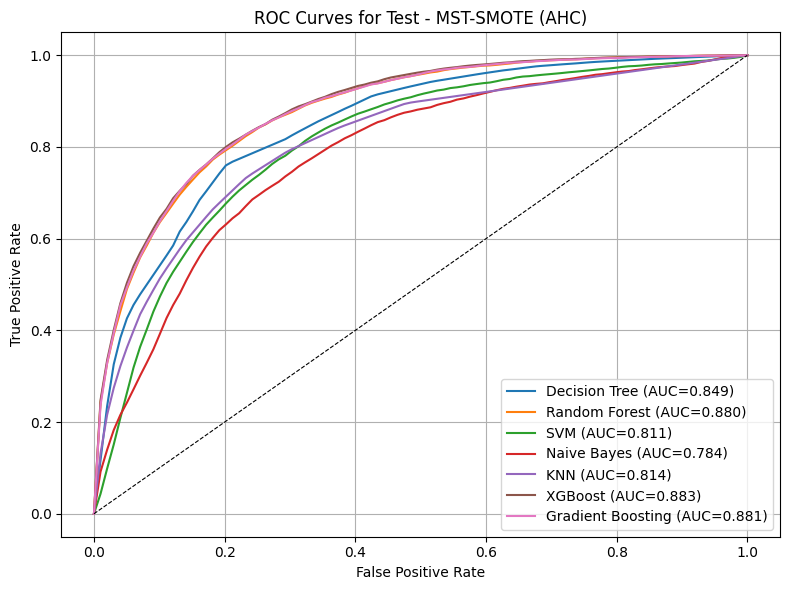

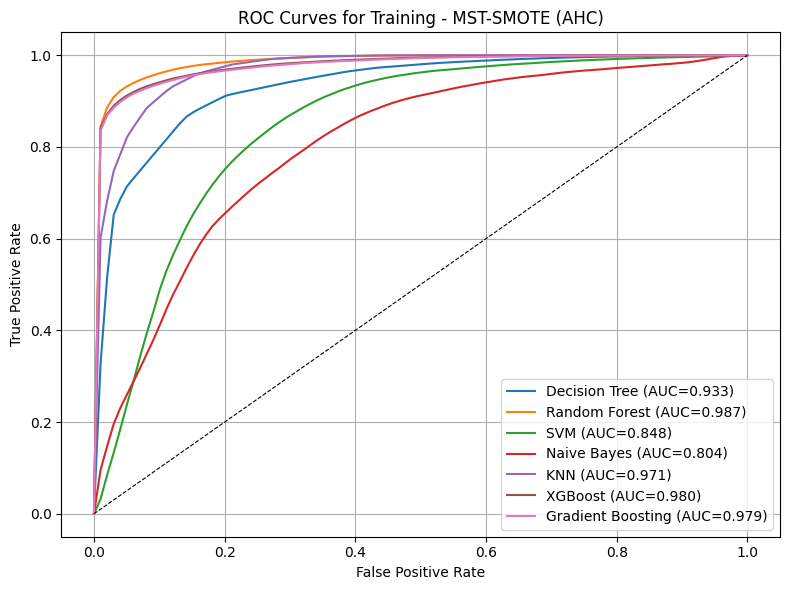


Tabela de Resultados - Teste:
   SMOTE Technique              Model  Accuracy       AUC  Precision  \
0  MST-SMOTE (AHC)      Decision Tree  0.823024  0.848667   0.434145   
1  MST-SMOTE (AHC)      Random Forest  0.878648  0.879691   0.603202   
2  MST-SMOTE (AHC)                SVM  0.725116  0.811221   0.321455   
3  MST-SMOTE (AHC)        Naive Bayes  0.752227  0.784258   0.333111   
4  MST-SMOTE (AHC)                KNN  0.820873  0.814370   0.424689   
5  MST-SMOTE (AHC)            XGBoost  0.883606  0.883456   0.636096   
6  MST-SMOTE (AHC)  Gradient Boosting  0.881623  0.880922   0.624923   

   Recall rate  F1-score  
0     0.646469  0.519328  
1     0.524788  0.561151  
2     0.772705  0.454010  
3     0.673287  0.445670  
4     0.594610  0.495403  
5     0.498353  0.558769  
6     0.499871  0.555364  

Tabela de Resultados - Treinamento:
   SMOTE Technique              Model  Accuracy       AUC  Precision  \
0  MST-SMOTE (AHC)      Decision Tree  0.862497  0.933206   0.86106

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Dicionários para armazenar as curvas ROC para cada técnica e modelo, separando teste e treinamento
roc_curves_test = {smote_name: {} for smote_name in smote_techniques.keys()}
roc_curves_train = {smote_name: {} for smote_name in smote_techniques.keys()}

# Listas para armazenar os resultados das tabelas para teste e treinamento
results_table_test = []
results_table_train = []

# Iteração entre técnicas de balanceamento e modelos
for smote_name, smote in smote_techniques.items():
    for model_name, model in models.items():
        print(f"\nAplicando {smote_name} com {model_name}")
        mean_fpr = np.linspace(0, 1, 100)

        # Listas para armazenar as curvas e métricas em cada fold (Teste)
        tprs_test = []
        aucs_test = []
        accuracies_test = []
        precisions_test = []
        recalls_test = []
        f1_scores_test = []

        # Listas para armazenar as curvas e métricas em cada fold (Treinamento)
        tprs_train = []
        aucs_train = []
        accuracies_train = []
        precisions_train = []
        recalls_train = []
        f1_scores_train = []

        # Validação cruzada
        for train_index, test_index in kf.split(X, y['Binary Mets']):
            # Separando os dados
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y['Binary Mets'].iloc[train_index], y['Binary Mets'].iloc[test_index]

            # Aplicar SMOTE somente no conjunto de treinamento
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

            # Normalizar os dados
            scaler = StandardScaler()
            X_train_res_scaled = scaler.fit_transform(X_train_res)
            X_test_scaled = scaler.transform(X_test)

            # Treinar o modelo com os dados balanceados
            model.fit(X_train_res_scaled, y_train_res)

            # ------------------------------
            # Avaliação no conjunto de Teste
            # ------------------------------
            y_pred_test = model.predict(X_test_scaled)
            y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

            # Curva ROC para teste
            fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
            interp_tpr_test = np.interp(mean_fpr, fpr_test, tpr_test)
            interp_tpr_test[0] = 0.0
            tprs_test.append(interp_tpr_test)
            aucs_test.append(auc(fpr_test, tpr_test))

            # Métricas para teste
            accuracies_test.append(accuracy_score(y_test, y_pred_test))
            precisions_test.append(precision_score(y_test, y_pred_test))
            recalls_test.append(recall_score(y_test, y_pred_test))
            f1_scores_test.append(f1_score(y_test, y_pred_test))

            # ------------------------------
            # Avaliação no conjunto de Treinamento
            # ------------------------------
            # Aqui, utiliza-se o conjunto de treinamento já balanceado
            y_pred_train = model.predict(X_train_res_scaled)
            y_pred_proba_train = model.predict_proba(X_train_res_scaled)[:, 1]

            # Curva ROC para treinamento
            fpr_train, tpr_train, _ = roc_curve(y_train_res, y_pred_proba_train)
            interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
            interp_tpr_train[0] = 0.0
            tprs_train.append(interp_tpr_train)
            aucs_train.append(auc(fpr_train, tpr_train))

            # Métricas para treinamento
            accuracies_train.append(accuracy_score(y_train_res, y_pred_train))
            precisions_train.append(precision_score(y_train_res, y_pred_train))
            recalls_train.append(recall_score(y_train_res, y_pred_train))
            f1_scores_train.append(f1_score(y_train_res, y_pred_train))

        # Cálculo das métricas médias para Teste
        mean_accuracy_test = np.mean(accuracies_test)
        mean_precision_test = np.mean(precisions_test)
        mean_recall_test = np.mean(recalls_test)
        mean_f1_test = np.mean(f1_scores_test)
        mean_auc_test = np.mean(aucs_test)

        # Cálculo das métricas médias para Treinamento
        mean_accuracy_train = np.mean(accuracies_train)
        mean_precision_train = np.mean(precisions_train)
        mean_recall_train = np.mean(recalls_train)
        mean_f1_train = np.mean(f1_scores_train)
        mean_auc_train = np.mean(aucs_train)

        # Armazenar as curvas ROC médias
        roc_curves_test[smote_name][model_name] = (mean_fpr, np.mean(tprs_test, axis=0), mean_auc_test)
        roc_curves_train[smote_name][model_name] = (mean_fpr, np.mean(tprs_train, axis=0), mean_auc_train)

        # Adicionar resultados à tabela de Teste
        results_table_test.append({
            "SMOTE Technique": smote_name,
            "Model": model_name,
            "Accuracy": mean_accuracy_test,
            "AUC": mean_auc_test,
            "Precision": mean_precision_test,
            "Recall rate": mean_recall_test,
            "F1-score": mean_f1_test
        })

        # Adicionar resultados à tabela de Treinamento
        results_table_train.append({
            "SMOTE Technique": smote_name,
            "Model": model_name,
            "Accuracy": mean_accuracy_train,
            "AUC": mean_auc_train,
            "Precision": mean_precision_train,
            "Recall rate": mean_recall_train,
            "F1-score": mean_f1_train
        })

# ------------------------------
# Plotar as curvas ROC para o conjunto de Teste
# ------------------------------
num_techniques = len(roc_curves_test)
fig_test, axes_test = plt.subplots(num_techniques, 1, figsize=(8, 6*num_techniques))
if num_techniques == 1:
    axes_test = [axes_test]
for i, technique in enumerate(roc_curves_test.keys()):
    ax = axes_test[i]
    for model_name, (fpr, tpr, mean_auc) in roc_curves_test[technique].items():
        ax.plot(fpr, tpr, label=f"{model_name} (AUC={mean_auc:.3f})")
    ax.plot([0, 1], [0, 1], 'k--', lw=0.8)
    ax.set_title(f"ROC Curves for Test - {technique}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right')
    ax.grid()
plt.tight_layout()
plt.show()

# ------------------------------
# Plotar as curvas ROC para o conjunto de Treinamento
# ------------------------------
num_techniques = len(roc_curves_train)
fig_train, axes_train = plt.subplots(num_techniques, 1, figsize=(8, 6*num_techniques))
if num_techniques == 1:
    axes_train = [axes_train]
for i, technique in enumerate(roc_curves_train.keys()):
    ax = axes_train[i]
    for model_name, (fpr, tpr, mean_auc) in roc_curves_train[technique].items():
        ax.plot(fpr, tpr, label=f"{model_name} (AUC={mean_auc:.3f})")
    ax.plot([0, 1], [0, 1], 'k--', lw=0.8)
    ax.set_title(f"ROC Curves for Training - {technique}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right')
    ax.grid()
plt.tight_layout()
plt.show()

# ------------------------------
# Criar e salvar as tabelas de resultados
# ------------------------------
results_df_test = pd.DataFrame(results_table_test)
results_df_train = pd.DataFrame(results_table_train)

results_df_test.to_csv("comparison_table_test.csv", index=False)
results_df_train.to_csv("comparison_table_train.csv", index=False)

print("\nTabela de Resultados - Teste:")
print(results_df_test)
print("\nTabela de Resultados - Treinamento:")
print(results_df_train)
